In [11]:
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pyRMT import optimalShrinkage

# I - Introduction

# II - Definition and detection of the problem

## 1 - Create a random correlation Matrix with specific eigen values

In [4]:
# normalization of the eigenvalues to have a trace(Matrix) = n, with n is the  size of the matrix ()
#  => because the correlation matrix trace remains invariant by the diagonalization

def normalaized_eigenvalues (input_eigenvalues):
    n = len(input_eigenvalues)
    return  n * input_eigenvalues / np.sum(input_eigenvalues)

# generate a random symmetric matrix with specific eigenvalues
def generate_wge(eigenvalues):
    n = len(eigenvalues)
    ortho_matrix = ortho_group.rvs(dim=n)
    diag_matrix = np.diag(eigenvalues)
    return ortho_matrix.T.dot(diag_matrix).dot(ortho_matrix)

# Givens rotation,it will be used to transform the matrix in generate_corr_wse function, to have 1's in diagonal

def givens(M, i, j):
    G = M
    Mii, Mij, Mjj = M[i,i], M[i,j], M[j,j]
    t = (Mij + np.sqrt(Mij**2 - (Mii-1)*(Mjj-1))) /(Mjj - 1)
    c = 1. / np.sqrt(1+t**2)
    s = c*t
    Mi, Mj = M[i], M[j]
    G[i], G[j] = c*Mi - s*Mj, s*Mi + c*Mj
    Mi, Mj = G[:,i], G[:,j]
    G[:,i], G[:,j] = c*Mi - s*Mj, s*Mi + c*Mj
    return G
    
def generate_corr_wse(eigs):
    n = len(eigs)
    eigen = normalaized_eigenvalues (eigs)
    corr = generate_wge(eigen)
    precision = 0.01
    converg = 0
    i = 0
    while(not converg):
        vec = np.diagonal(corr)
        if np.sum(abs(vec-1)>precision)==0:
            converg = 1
        else:
            bigger = np.arange(len(vec))[(vec>1)]
            smaller = np.arange(len(vec))[(vec<1)]
            i,j = smaller[0], bigger[-1]
            if i>j:
                i,j = bigger[0], smaller[-1]
            corr = givens(corr, i, j)
            corr[i,i]=1
    return corr
def get_random_eigen_values (min,max,size):
     return np.random.randint(min,max,size)

## 2- Some Tests 

In [5]:
# Generate a symmetric matrix with specific eigen values
a = generate_wge([1,2,3])
a

array([[ 1.52098741, -0.01650952, -0.54064977],
       [-0.01650952,  2.75162051, -0.52256531],
       [-0.54064977, -0.52256531,  1.72739207]])

In [29]:
# diagonalized matrix
LA.eig(a)[0]

array([3., 2., 1.])

In [32]:
a = generate_corr_wse(np.array([5,4,3]))

 normalized eigenvalues are :  [1.25 1.   0.75]


In [33]:
LA.eig(a)[0]

array([0.75, 1.25, 1.  ])

In [6]:
generate_wge([1,2,3])

array([[ 1.15421881,  0.16978329, -0.39745177],
       [ 0.16978329,  2.05708533,  0.37799851],
       [-0.39745177,  0.37799851,  2.78869585]])

In [7]:
a = generate_corr_wse(np.array([5,4,3]))
a

array([[ 1.00000000e+00, -6.10622664e-16, -9.60435774e-02],
       [-7.07767178e-16,  1.00000000e+00, -2.30815145e-01],
       [-9.60435774e-02, -2.30815145e-01,  1.00000000e+00]])

In [8]:
generate_corr_wse(get_random_eigen_values (0,10,3))

array([[ 1.00000000e+00,  5.27355937e-16,  8.73288753e-01],
       [ 5.27355937e-16,  1.00000000e+00, -4.87202990e-01],
       [ 8.73288753e-01, -4.87202990e-01,  1.00000000e+00]])

## 3- Simalting Data from a correlation Matrix 

In [19]:
def generate_data (correlation_matrix , ration_q):
    
    # q = variables / observations
    num_variables = correlation_matrix.shape[0]
    
    num_samples = int(num_variables//q)
    # starting with mean = 0 
    mu = np.zeros(num_variables)
    y = np.random.multivariate_normal(mu, correlation_matrix, size=num_samples)
    df = pd.DataFrame(y)
    return df
def get_data_sample(data, q):
    return data.sample(int(data.shape[1]//q))

## 4-reproduction of the problem for a Dataframe with 180 variables with different values of q

In [17]:
Number_variables = 180
q = 0.1
eigen_values = normalaized_eigenvalues(get_random_eigen_values (0,10,Number_variables))
r = generate_corr_wse(eigen_values)

In [20]:
data = generate_data (r , 0.001)

In [21]:
data_01 = get_data_sample(data, 0.1) # q = 0.1
data_1 = get_data_sample(data, 1)   # q = 1
data_2 = get_data_sample(data, 2)   # q = 2 

In [95]:
# comuting spectrum for different samples 

x =  np.array(range(1, Number_variables+1))

spectrum =  LA.eig(data.corr().to_numpy())[0]
spectrum.sort()
spectrum = spectrum[::-1]

spectrum_01 =  LA.eig(data_01.corr().to_numpy())[0]
spectrum_01.sort()
spectrum_01 = spectrum_01[::-1]

spectrum_1 =  LA.eig(data_1.corr().to_numpy())[0]
spectrum_1.sort()
spectrum_1 = spectrum_1[::-1]

spectrum_2 =  LA.eig(data_2.corr().to_numpy())[0]
spectrum_2.sort()
spectrum_2 = spectrum_2[::-1]


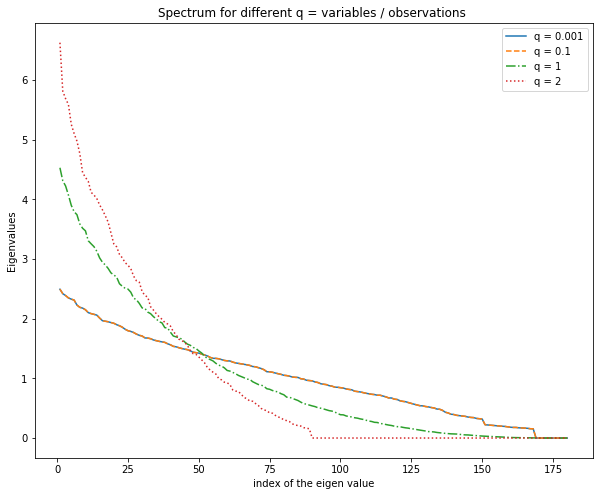

In [102]:
plt.figure(figsize=(10,8))
plt.plot(x, spectrum, linestyle='-',label = 'q = 0.001')  
plt.plot(x, spectrum_01, linestyle='--',label = 'q = 0.1')  
plt.plot(x, spectrum_1, linestyle='-.',label = 'q = 1')  
plt.plot(x, spectrum_2, linestyle=':',label = 'q = 2')  

plt.title("Spectrum for different q = variables / observations ")
plt.xlabel("index of the eigen value")
plt.ylabel("Eigenvalues")

plt.legend()

<mark>Problem well detected !!  => overestimation for the largest eigenvalues, and underetismations for the smallest eigenvalues<mark> 

# III-Models

## 1- Optimal Rotational Invariant Estimator ()

In [24]:
data_2

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
1548,0.446818,-1.017664,-1.139425,0.809471,-0.093025,-0.080122,2.574357,1.385102,-0.068560,-0.508273,...,-0.410773,1.653515,0.353922,1.736217,-0.719906,0.153589,0.442005,0.535809,0.273673,0.159906
820,-0.031884,-1.317549,-1.128652,-0.624304,0.948433,-0.944735,0.987612,-0.410877,-1.395262,1.259741,...,-1.222305,0.665944,-0.184437,-1.679526,0.928825,-0.541012,0.845984,0.605799,-1.361943,1.435279
819,0.636622,0.552111,0.366118,1.027962,0.333266,0.608111,-1.958251,-2.833011,0.202222,-0.197528,...,-0.636105,0.674961,-0.836353,1.906387,-0.977020,-0.502659,-0.510683,-2.795314,1.284818,0.718752
756,1.536564,-0.296977,0.474794,0.130100,1.603302,0.194492,-0.161750,0.741803,-0.126814,-0.455427,...,-0.162078,-0.057744,-1.624589,0.918340,-0.647019,-0.966120,1.416387,0.544367,1.458158,1.569224
595,-0.865721,1.956983,-0.431409,0.233169,0.371796,-0.875772,1.882688,2.543469,-0.190630,0.181384,...,1.568500,0.501574,0.239746,0.870037,-0.109799,0.117708,0.268306,-0.038237,1.054207,-0.949317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,-0.666467,0.889926,-0.156995,0.287133,0.800295,-0.601447,-1.369385,-0.659298,-0.860517,-0.578895,...,-1.623749,-0.585582,0.265389,-0.744973,0.054744,-1.298545,1.948239,0.317150,0.444983,-0.657196
20,0.395232,-0.881779,0.477222,-2.259656,0.206559,1.155232,0.570999,-0.903828,-1.908207,-0.520393,...,0.065902,-1.386422,0.310233,0.175546,-0.135664,-1.108503,-0.556097,-0.555859,0.772028,2.070498
1237,0.736742,-0.621179,-0.005321,0.193313,-0.582153,0.705279,-0.175475,-0.658281,0.654692,-0.992716,...,0.126438,2.028569,0.116441,-0.012964,-1.270488,0.463892,-0.560994,0.262002,0.832064,0.424645
1399,-0.157719,-1.047366,-1.186342,0.129948,-0.090044,-0.192167,1.481305,-1.608023,-1.285507,0.519017,...,1.468693,-0.942189,-0.953115,0.799349,0.382941,0.160759,-1.184224,-1.324968,-0.477314,-0.314100


In [ ]:
help(optimalShrinkage)